<a href="https://colab.research.google.com/github/emilianog4/Data-Science-Projects/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentacion de clientes**
### Utilizando análisis **RFM** y el algoritmo de clustering **K-means**.


---



Importamos las librerias que vamos a necesitar para el proyecto

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Leemos el archivo excel `.xlsx`

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx')

Visualizamos las primeras filas del dataset

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Eliminamos las columnas innecesarias para nuestro analisis

In [4]:
df = df.drop(['StockCode', 'Description', 'Country'], axis=1)

Renombramos las columnas para que tengan el mismo formato

In [5]:
df = df.rename(columns={'Invoice': 'order_id', 'Quantity': 'quantity', 'InvoiceDate': 'order_date',
'Price': 'unit_price', 'Customer ID': 'customer_id'})

Con `.describe()` analizamos valores como:
* count
* mean
* max
* min

In [6]:
df.describe()

,quantity,order_date,unit_price,customer_id
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


> Vemos algo atípico: Tanto en la columna `quantity` como en `unit_price` hay valores negativos, lo cual en principio es contraintuitivo

Aqui visualizamos cuales son esas filas en el dataset con valores negativos de `quantity` y `unit_price`

In [7]:
df[(df.quantity<0) | (df.unit_price<0)]

,order_id,quantity,order_date,unit_price,customer_id
178,C489449,-12,2009-12-01 10:33:00,2.95,16321.0
179,C489449,-6,2009-12-01 10:33:00,1.65,16321.0
180,C489449,-4,2009-12-01 10:33:00,4.25,16321.0
181,C489449,-6,2009-12-01 10:33:00,2.10,16321.0
182,C489449,-12,2009-12-01 10:33:00,2.95,16321.0
...,...,...,...,...,...
525231,538159,-18,2010-12-09 17:17:00,0.00,NaN
525232,538158,-32,2010-12-09 17:17:00,0.00,NaN
525234,538161,-100,2010-12-09 17:25:00,0.00,NaN
525235,538162,-100,2010-12-09 17:25:00,0.00,NaN


> 12329 filas contienen valores negativos


In [8]:
df.isna().sum(axis=0)

order_id            0
quantity            0
order_date          0
unit_price          0
customer_id    107927
dtype: int64

> En `customer_id` ademas tenemos 107927 valores nulos

## **CUSTOMER SEGMENTATION**
### **Engineer features to cluster**
Tenemos que construir variables que involucren el comportamiento de los clientes.
* **Recency**: ¿cuánto tiempo ha pasado desde que el cliente realizó un pedido?
 * **Low**: recientemente
 * **High**: hace mucho tiempo
* **Frequency**: ¿con qué frecuencia el cliente ha realizado pedidos o interactuado con la empresa dentro de un período determinado?
* **Monetary**: ¿cuánto ha gastado el cliente durante un período específico?

### **Creacion de columnas**
### Total Purchase
Creamos una nueva columna llamada `'line_price'` la cual contiene el resultado de multiplicar el precio del producto por la cantidad vendida para obtener un **total**

In [9]:
df['line_price'] = df['unit_price']* df['quantity']

Ahora modificamos nuestro `df` para que solo contenga los valores cuyo `line_price` sea positivo, de esta manera solucionamos el problema de esos valores dudosos que habiamos observado anteriormente

In [10]:
df = df[df['line_price'] > 0]
df.tail()

,order_id,quantity,order_date,unit_price,customer_id,line_price
525456,538171,2,2010-12-09 20:01:00,2.95,17530.0,5.90
525457,538171,1,2010-12-09 20:01:00,3.75,17530.0,3.75
525458,538171,1,2010-12-09 20:01:00,3.75,17530.0,3.75
525459,538171,2,2010-12-09 20:01:00,3.75,17530.0,7.50
525460,538171,2,2010-12-09 20:01:00,1.95,17530.0,3.90


### Date
Utilizamos la función `max()` para encontrar un valor maximo, en nuestro caso, para encontrar la fecha más reciente entre todas las fechas de la columna `order_date`.

In [11]:
max(df['order_date'])

Timestamp('2010-12-09 20:01:00')

creamos la variable `end_date` la cual calcula una **fecha final**, que es un día posterior a la fecha más reciente calculada con `(max(df['order_date']))` en la columna `order_date`.

In [12]:
end_date = max(df['order_date']) + dt.timedelta(days=1)

### Aggregated table
Transformamos el DataFrame original `df` en un nuevo DataFrame `df_rfm` que contiene métricas **RFM** (Recency, Frequency, Monetary) para cada cliente por `customer_id`.  

In [13]:
df_rfm = df.groupby('customer_id').agg(
    recency=('order_date', lambda x: (end_date - x.max()).days),
    frequency=('order_id', 'count'),
    monetary=('line_price', 'sum')
)
df_rfm.head()

,recency,frequency,monetary
customer_id,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2671.14
12351.0,11,21,300.93


> Estas métricas se pueden utilizar para analizar el **comportamiento del cliente**, como identificar a los **clientes más recientes**, **más frecuentes** y que **gastan más**.

In [14]:
df_rfm.describe()

,recency,frequency,monetary
count,4312.000000,4312.000000,4312.000000
mean,91.171846,94.541744,2048.238236
std,96.860633,202.046410,8914.481280
min,1.000000,1.000000,2.950000
25%,18.000000,18.000000,307.987500
50%,53.000000,44.000000,706.020000
75%,136.000000,102.000000,1723.142500
max,374.000000,5570.000000,349164.350000


Creamos un grafico de cajas para `Recency`, `Frequency` y `Monetary` para visualizar **media**, **min**, **max** y **valores atipicos** en cada columna.

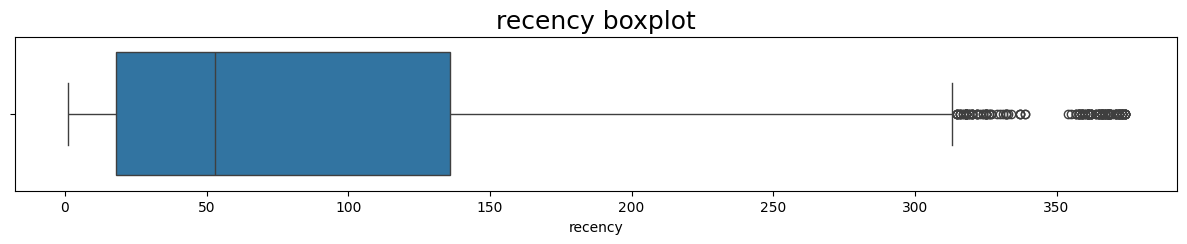

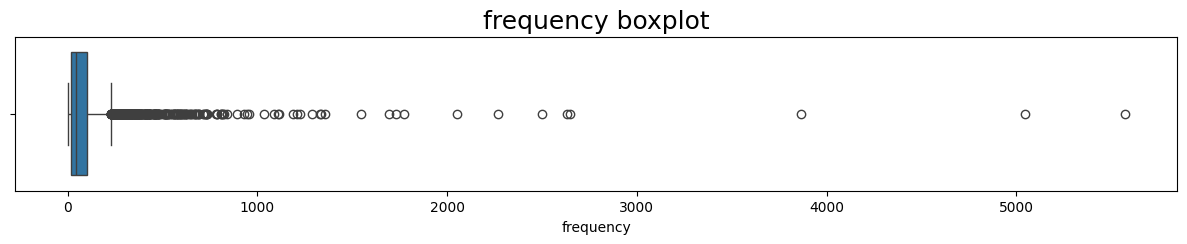

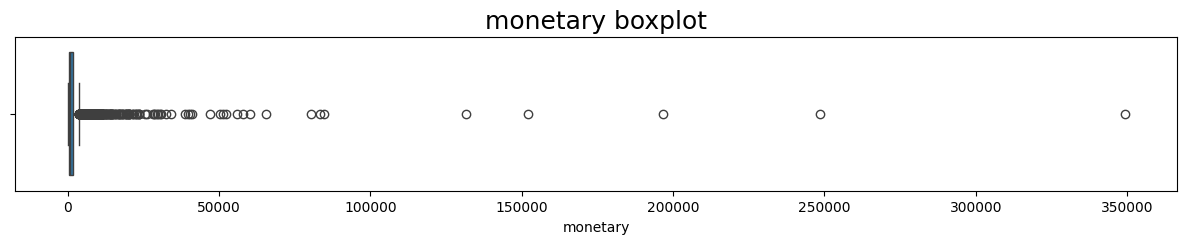

In [15]:
for i in df_rfm.columns:
  plt.figure(figsize=(15,2))
  ax = sns.boxplot(x=df_rfm[str(i)])
  print('')
  plt.title(str(i)+' boxplot',fontsize=18)
  plt.show()

### Preprocesamos los datos
Transformamos los valores de `df_rfm` aplicando el logaritmo natural con uno agregado a cada elemento.

In [16]:
df_log = np.log1p(df_rfm)

> Esta transformación se utiliza a menudo en el preprocesamiento de datos para tareas de aprendizaje automático, especialmente cuando se trata de *datos sesgados* o *no negativos*. La adición de uno asegura que el logaritmo esté definido para todos los valores.

Estandarizamos los datos utilizando la clase `StandardScaler` de scikit-learn, transformándolas para que tengan una **media de cero** y una **desviación estándar de uno**.

In [17]:
scaler = StandardScaler()
scaler.fit(df_log)
df_norm = scaler.transform(df_log)

Ahora creamos el dataframe `df_norm` con las columnas `recency` `frequency` y `monetary`

In [18]:
df_norm = pd.DataFrame(df_norm, columns =["recency", "frequency", "monetary"], index= df_rfm.index)
df_norm.head()

,recency,frequency,monetary
customer_id,,,
12346.0,0.966262,-0.200749,-0.540688
12347.0,-1.900165,0.394219,0.447651
12348.0,0.355000,-0.582831,-0.943904
12349.0,-0.055302,0.678152,0.996204
12351.0,-1.054928,-0.545943,-0.707671


Graficamos la distribucion de los valores en `recency`

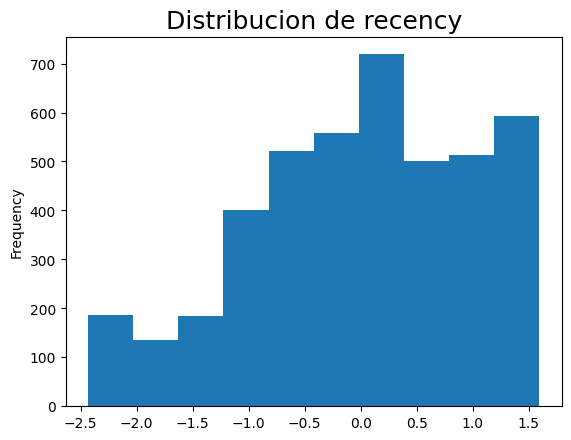

In [58]:
df_norm['recency'].plot(kind="hist")
plt.title('Distribucion de recency',fontsize=18)
plt.show()

Graficamos la distribucion de los valores en `monetary`

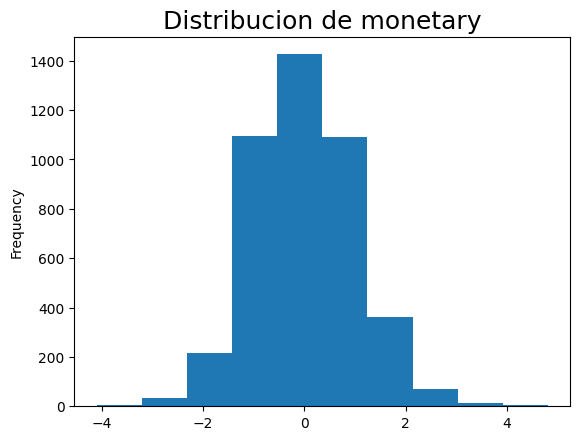

In [59]:
df_norm['monetary'].plot.hist()
plt.title('Distribucion de monetary',fontsize=18)
plt.show()

Graficamos la dispersion de los valores entre `recency` y `frequency`

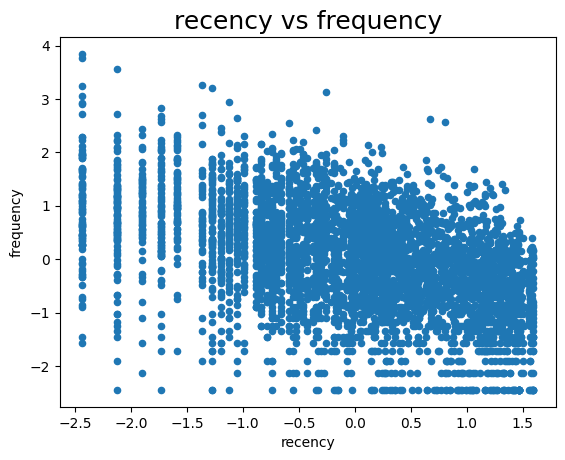

In [60]:
df_norm.plot.scatter('recency','frequency')
plt.title('recency vs frequency',fontsize=18)
plt.show()

Graficamos la dispersion de los valores entre `recency` y `monetary`

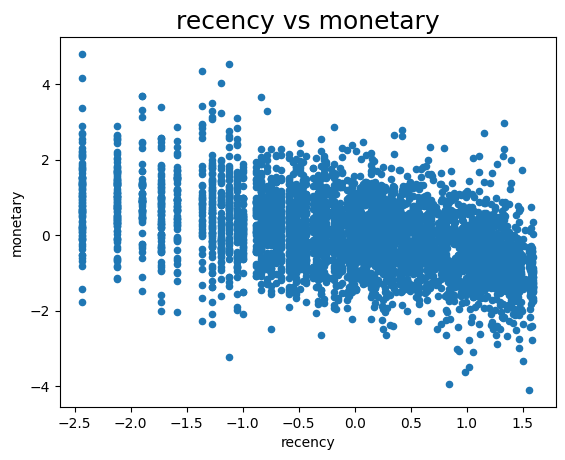

In [63]:
df_norm.plot.scatter('recency','monetary')
plt.title('recency vs monetary',fontsize=18)
plt.show()

## **Clustering**

 Aplicamos el algoritmo de agrupación en k-means a los datos estandarizados en `df_norm`.  
  Utilizamos la clase `KMeans()` de la biblioteca `scikit-learn` para realizar la agrupación.

In [24]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto")
kmeans.fit(df_norm)

KMeans(n_clusters=4, n_init='auto', random_state=0)

> Agrupamos los datos en 4 clústeres en función de su similitud.  
El algoritmo k-means tiene como objetivo **minimizar la varianza dentro del clúster**, lo que significa que los puntos de datos dentro de cada clúster deben ser lo más similares posible, mientras que los puntos de datos entre clústeres deben ser lo más diferentes posible.

In [25]:
# kmeans.labels_ devuelve las etiquetas de los clusters y count la cantidad de elementos en cada grupo
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1215,  933, 1242,  922]))

In [26]:
# Imprimimos por pantalla los nombres de los clusters junto con la cantidad de elementos que contiene cada uno
print(dict(pd.Series(kmeans.labels_).value_counts()))

{2: 1242, 0: 1215, 1: 933, 3: 922}


 Agregamos una nueva columna llamada `cluster` que contiene las etiquetas o nombres de cada cluster

In [27]:
df_norm['cluster'] = kmeans.labels_

Luego cambiamos el tipo de datos de la columna `cluster` por tipo **categorico**

In [28]:
df_norm['cluster'] = df_norm['cluster'].astype('category')

En un grafico de dispersion vemos como se separan o agrupan los clusters por cada color con respecto a `recency` y `monetary`

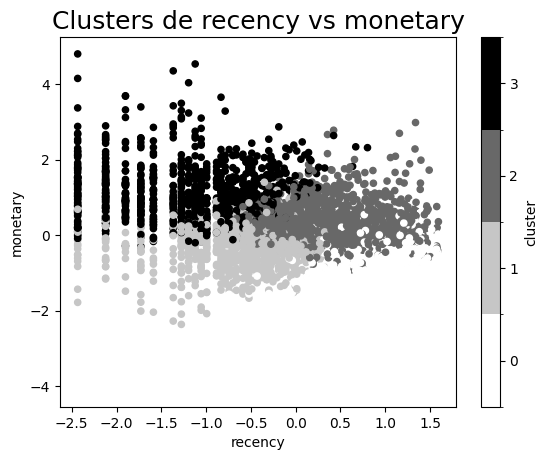

In [67]:
df_norm.plot(x='recency', y='monetary', c='cluster', kind='scatter')
plt.title('Clusters de recency vs monetary',fontsize=18)
plt.show()

En un grafico de dispersion vemos como se separan o agrupan los clusters por cada color con respecto a `frequency` y `monetary`

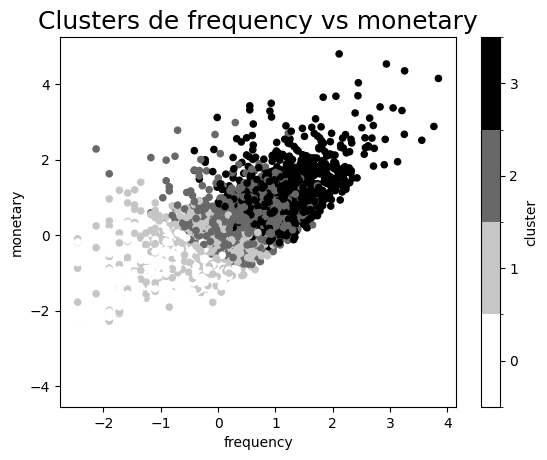

In [68]:
df_norm.plot(x='frequency', y='monetary', c='cluster', kind='scatter')
plt.title('Clusters de frequency vs monetary',fontsize=18)
plt.show()

### **Cluster segmentation**
Aplicamos la misma idea pero esta vez sobre el `df_rfm`

In [32]:
# Creamos la nueva columna cluster
df_rfm['cluster'] = kmeans.labels_

In [33]:
# Transformamos el tipo a categorico
df_rfm['cluster'] = df_rfm['cluster'].astype('category')

Agrupamos por cada cluster la media de cada columna, ademas el tamaño del respectivo cluster, redondeamos a una cifra decimal y ordenamos los valores por `recency`

In [34]:
df_rfm.groupby('cluster').agg(
recency=('recency', 'mean'),
frequency=('frequency', 'mean'),
monetary=('monetary', 'mean'),
cluster_size=('monetary', 'count')
).round(1).sort_values(by='recency')

,recency,frequency,monetary,cluster_size
cluster,,,,
3,14.0,272.3,6484.6,922
1,25.2,34.8,561.7,933
2,100.0,84.9,1598.1,1242
0,191.4,15.4,283.3,1215


> El resultado es la tabla que resume por cada `cluster` la **media** de `recency` `frequency` `monetary` y `cluster_size`

### Visualizacion de clusters
Finalmente mostramos el resultado en un grafico de barras dividido por cada cluster

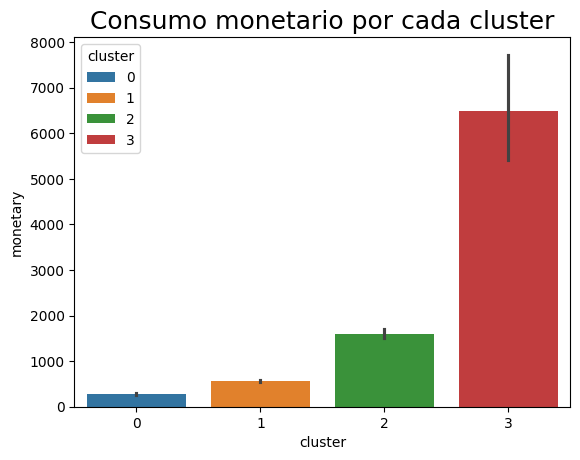

In [70]:
sns.barplot(data=df_rfm, x='cluster', y='monetary', hue='cluster')
plt.title('Consumo monetario por cada cluster',fontsize=18)
plt.show()

> Vemos que el **cluster 3 es el que mas dinero gasta**, mientras que el **cluster 0 es el que menos** lo hace

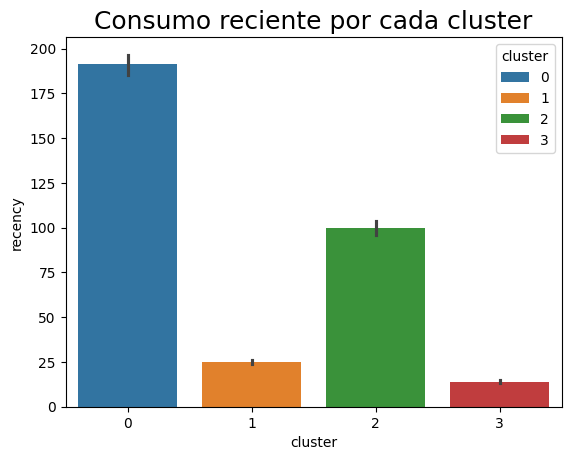

In [71]:
sns.barplot(data=df_rfm, x='cluster', y='recency', hue='cluster')
plt.title('Consumo reciente por cada cluster',fontsize=18)
plt.show()

> Ademas el **grupo 3 es el que mas recientemente ha hecho una compra**, **el grupo 0 es en el que mas dias pasaron desde su ultima compra**.

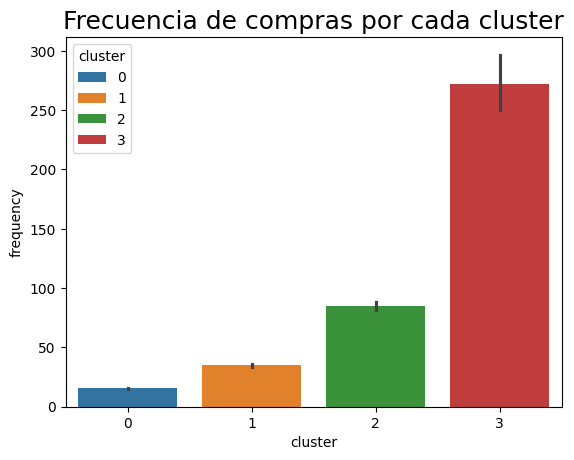

In [73]:
sns.barplot(data=df_rfm, x='cluster', y='frequency', hue='cluster')
plt.title('Frecuencia de compras por cada cluster',fontsize=18)
plt.show()

> Por ultimo y siguiendo con esta tendencia, **el grupo 3 es el que con mas frecuencia realiza compras** mientras que **el grupo 0 es el que menos lo hace**